In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Overview

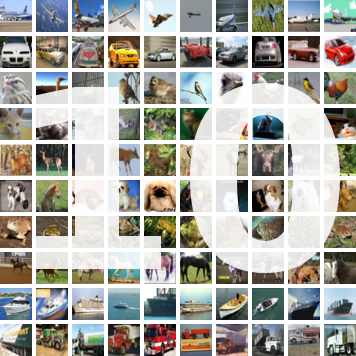

In this notebook we will use a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. The task is pretty hard, as the images from the dataset are not that easy to clasify with great accuracy even for a person. But PyTorch let us build pretty easilly a CNN, whill is of great help.

# Introduction to Convolutional Neural Network (CNN)

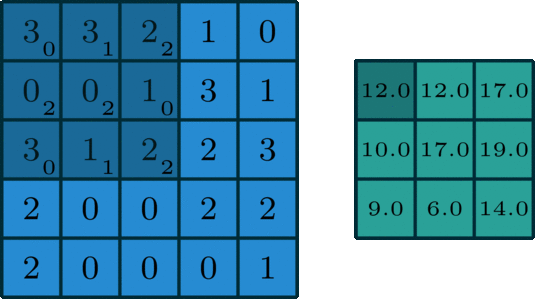

A Convolutional Neural Network (CNN) is a class of artificial neural network most commonly applied to analyze visual imagery. They are specifically designed to process pixel data and are used in image recognition and processing.

CNNs were the models that allowed computer vision to scale from simple applications to powering sophisticated products and services.

A great intro into the subject can be found [here](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

# Imports

Let's start with out imports. We import a bounch of things from torch, some utils and some data for plotting.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split, SubsetRandomSampler, Subset
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import pandas as pd
import matplotlib.pyplot as plt
import random

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Loading and prepparing the data

Load the data from disk, we will use the available PyTorch functionality for this.

In [2]:
dataset = torchvision.datasets.CIFAR10(root="/kaggle/input/cifar10-python/", train=True, download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root="/kaggle/input/cifar10-python/", train=False, download=False, transform=transforms.ToTensor())

Split the train data into train and validate, create data loaders and define the classes and the batch size constant.

# Population

In [ ]:
batchSize = 200


trainset, validateset = random_split(dataset, [45000, 5000])

train = DataLoader(trainset, batchSize, shuffle=True)
validate = DataLoader(validateset, batchSize, shuffle=True)
testLoader = DataLoader(testset, batch_size=batchSize, shuffle=False)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [ ]:

train = DataLoader(trainset, batchSize, shuffle=True, num_workers=2, pin_memory=True)
validate = DataLoader(validateset, batchSize, shuffle=True, num_workers=2, pin_memory=True)
testLoader = DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=4, pin_memory=True)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Batch size: 20, subsample size: 1000, 

# Subsample

In [4]:
batchSize = 40

trainset, validateset = random_split(dataset, [45000, 5000])

trainset_indices = random.sample(range(len(trainset)), k=2000)
trainset_subset = Subset(trainset, trainset_indices)


validateset_indices = random.sample(range(len(validateset)), k=200)
validateset_subset = Subset(validateset, validateset_indices)



In [5]:

train = DataLoader(trainset_subset, batchSize, shuffle=True, num_workers=2, pin_memory=True)
validate = DataLoader(validateset_subset, batchSize, shuffle=True, num_workers=2, pin_memory=True)
testLoader = DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=2, pin_memory=True)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

# Display some of the images
Display some of the pictures, to verify everything is ok, and also it will make some good plots :)

First let's display the first batch of 200 images from the training set.

In [ ]:
for images, labels in train:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
    break

Now let's display a few of the images a little bigger, also with a their lable as a title.

In [ ]:
for i in range(0, 12):
    img, label = validateset[i]
    plt.subplot(3,4,i+1)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

As you can see this is a pretty hard problem, as many of the images are hard for even a human. CNNs to the rescue!

# Creating the CNN Classification Model class

We will define a class that will serve as our classification model. We will levarage the functionality provided to us by PyTorch.

In [6]:
class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # define all the transformers sequencially
        self.network = nn.Sequential(
            
            # here we define 3 channels as our inpur, 32 channels as the output, 
            # the size of the kernel, the padding and the stride
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # apply a max pool layer
            nn.MaxPool2d(2, 2),

            # continue the process in the next two layers
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # final layer, we decrease the number of outputs to 10, which is our number of classes
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def trainingStep(self, batch, device):
        # unpack the images and labels from the
        images, labels = batch
        
        images=images.to(device)
        labels = labels.to(device)

        # call the model itself
        out = self(images)

        # compute the loss
        loss = F.cross_entropy(out, labels)

        return loss

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def validationStep(self, batch, device):
        images, labels = batch
        images=images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accuracy = self.accuracy(out, labels)

        return {"loss": loss, "accuracy": accuracy}

    def validationEpochEnd(self, outputs):

        batchLosses = [row["loss"] for row in outputs]
        epochLosses = torch.stack(batchLosses).mean()
        batchAcc = [row["accuracy"] for row in outputs]
        epochAcc = torch.stack(batchAcc).mean()

        return {"loss": epochLosses.item(), "accuracy": epochAcc.item()}

    def forward(self, x):
        return self.network(x)

In [12]:
class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # define all the transformers sequencially
        self.network = nn.Sequential(
            
            # here we define 3 channels as our inpur, 32 channels as the output, 
            # the size of the kernel, the padding and the stride
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # apply a max pool layer
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # apply a max pool layer
            nn.MaxPool2d(2, 2),


            # continue the process in the next two layers
            #nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            #nn.ReLU(),
            #nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            #nn.ReLU(),
            #nn.MaxPool2d(2, 2),

            #nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            #nn.ReLU(),
            #nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            #nn.ReLU(),
            #nn.MaxPool2d(2, 2),

            # final layer, we decrease the number of outputs to 10, which is our number of classes
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def trainingStep(self, batch, device):
        # unpack the images and labels from the
        images, labels = batch
        
        images=images.to(device)
        labels = labels.to(device)

        # call the model itself
        out = self(images)

        # compute the loss
        loss = F.cross_entropy(out, labels)

        return loss

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def validationStep(self, batch, device):
        images, labels = batch
        images=images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accuracy = self.accuracy(out, labels)

        return {"loss": loss, "accuracy": accuracy}

    def validationEpochEnd(self, outputs):

        batchLosses = [row["loss"] for row in outputs]
        epochLosses = torch.stack(batchLosses).mean()
        batchAcc = [row["accuracy"] for row in outputs]
        epochAcc = torch.stack(batchAcc).mean()

        return {"loss": epochLosses.item(), "accuracy": epochAcc.item()}

    def forward(self, x):
        return self.network(x)

# Training the CNN classification model

We will first define an evaluation method, a train method and then we will train our model.

In [7]:
# the evaluation model, please note we will disable the gradiant descent on this method
@torch.no_grad()
def evaluateModel(model, validationLoader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # puts the model in eval mode
    model.eval()
    out = [model.validationStep(batch, device) for batch in validationLoader]

    return model.validationEpochEnd(out)

In [8]:
# method for training the model
def trainModel(epochs, lr, model, trainLoader, validationLoader, optimizationFunction=torch.optim.SGD):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = optimizationFunction(model.parameters(), lr)
   
    for epoch in range(epochs):
        #print(f"training epoch {epoch}")
        # puts the model in train mode
        model.train()
        trainingLosses = []

        # training
        for batch in trainLoader:
            
            loss = model.trainingStep(batch, device)
            trainingLosses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #print(f"after training epoch {epoch} we get results {evaluateModel(model, validationLoader)}")

Now we will instantiate the model and performn an evaluation on it, before training the model. Because the weights of the model are randomly initliasied we have an accuracy of about 10% (100% devided by the number of classes). 

In [9]:
# instantiate the model
model = Cifar10Classifier()
# do an evaluation of the model on the tra
evaluateModel(model, validate)

{'loss': 2.3046529293060303, 'accuracy': 0.10999999940395355}

Now let's do the training of the model

In [ ]:
%%time
trainModel(6, 0.001, model, trainLoader=train, validationLoader=validate, optimizationFunction=torch.optim.Adam)

In [ ]:
evaluateModel(model, validate)['loss']

# Bootstrap from subset

In [9]:
def get_emp_scores(num_bootstraps):
    loss_scores = []
    accuracies = []
  
    for i in range(num_bootstraps):
        if(i%10 == 0):
            print(i)
        #create boostrap
        
        bootstrap_indices = random.choices(range(len(train)), k=len(train))
        boostrap_subset = Subset(train, bootstrap_indices)

        #train model and append test score
        
        # instantiate the model
        model = Cifar10Classifier()
       
        trainModel(6, 0.001, model, trainLoader=train, validationLoader=validate, optimizationFunction=torch.optim.Adam)
        evaluation = evaluateModel(model, validate)
        loss_scores.append(evaluation['loss'])
        accuracies.append(evaluation['accuracy'])
    return loss_scores, accuracies

In [10]:
losses1, acc1 = get_emp_scores(100)


0
10
20
30
40
50
60
70
80
90


In [13]:
#switch CNN class before running
losses2, acc2 = get_emp_scores(100)

0
10
20
30
40
50
60
70
80
90


# Testing Methods

In [16]:
# STD
from typing import List, Callable, Union, Optional
from warnings import warn

# EXT
from joblib import Parallel, delayed, wrap_non_picklable_objects
from joblib.externals.loky import set_loky_pickler
import numpy as np
import pandas as pd
import psutil
from scipy.stats import norm as normal
from tqdm import tqdm



In [18]:
!pip install deepsig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 5.1 MB/s eta 0:00:00


In [19]:
# PKG
from deepsig.conversion import (
    ArrayLike,
    ScoreCollection,
    score_pair_conversion,
)
from deepsig.utils import _progress_iter, _get_num_models

In [20]:
"""
Re-implementation of Almost Stochastic Order (ASO) by `Dror et al. (2019) <https://arxiv.org/pdf/2010.03039.pdf>`_.
The code here heavily borrows from their `original code base <https://github.com/rtmdrr/DeepComparison>`_.
"""



# MISC
set_loky_pickler("dill")  # Avoid weird joblib error with multi_aso


@score_pair_conversion
def aso(
    scores_a: ArrayLike,
    scores_b: ArrayLike,
    confidence_level: float = 0.95,
    num_comparisons: int = 1,
    num_samples: int = 1000,
    num_bootstrap_iterations: int = 1000,
    dt: float = 0.005,
    num_jobs: int = 1,
    show_progress: bool = True,
    seed: Optional[int] = None,
    _progress_bar: Optional[tqdm] = None,
) -> float:
    """
    Performs the Almost Stochastic Order test by Dror et al. (2019). The function takes two list of scores as input
    (they do not have to be of the same length) and returns an upper bound to the violation ratio - the minimum epsilon
    threshold. `scores_a` should contain scores of the algorithm which we suspect to be better (in this setup,
    higher = better).
    The null hypothesis (which we would like to reject), is that the algorithm that generated `scores_a` is
    *not* better than the one `scores_b` originated from. If the violation ratio is below 0.5, the null hypothesis can
    be rejected safely (and the model scores_a belongs to is deemed better than the model of scores_b). Intuitively, the
    violation ratio denotes the degree to which total stochastic order (algorithm A is *always* better than B) is being
    violated. The more scores and the higher num_samples / num_bootstrap_iterations, the more reliable is the result.
    Parameters
    ----------
    scores_a: List[float]
        Scores of algorithm A.
    scores_b: List[float]
        Scores of algorithm B.
    confidence_level: float
        Desired confidence level of test. Set to 0.95 by default.
    num_comparisons: int
        Number of comparisons that the test is being used for. Is used to perform a Bonferroni correction.
    num_samples: int
        DEPRECATED: Number of samples from the score distributions during every bootstrap iteration when estimating
        sigma. Currently ignored, and will be deprecated in next major release.
    num_bootstrap_iterations: int
        Number of bootstrap iterations when estimating sigma.
    dt: float
        Differential for t during integral calculation.
    num_jobs: int
        Number of threads that bootstrap iterations are divided among.
    show_progress: bool
        Show progress bar. Default is True.
    seed: Optional[int]
        Set seed for reproducibility purposes. Default is None (meaning no seed is used).
    _progress_bar: Optional[tqdm]
        Hands over a progress bar object when called by multi_aso(). Only for internal use.
    Returns
    -------
    float
        Return an upper bound to the violation ratio. If it falls below 0.5, the null hypothesis can be rejected.
    """
    assert (
        len(scores_a) > 0 and len(scores_b) > 0
    ), "Both lists of scores must be non-empty."
    assert (
        num_bootstrap_iterations > 0
    ), "num_samples must be positive, {} found.".format(num_bootstrap_iterations)
    assert (
        num_jobs > 0 or num_jobs == -1
    ), "Number of jobs has to be at least 1 or -1, {} found.".format(num_jobs)
    assert (
        num_comparisons > 0
    ), "Number of comparisons has to be at least 1, {} found.".format(num_comparisons)

    # Determine the maximum number of jobs possible
    if num_jobs == -1:
        num_jobs = psutil.cpu_count(logical=True)

        if num_jobs is None:
            warn(
                "Number of available CPUs could not be determined, setting num_jobs=1."
            )
            num_jobs = 1

    # TODO: Remove in future version
    if num_samples != 1000:
        warn(
            "'num_samples' argument is being ignored in the current version and will be deprecated in version 1.3!",
            DeprecationWarning,
        )

    # TODO: Remove in future version
    if confidence_level < 0.95:
        warn(
            "'confidence_level' was refactored in version 1.2.4 to be more intuitive and usually should be in the .95 -"
            f".99 range, but {confidence_level} was found. If you tried to adjust the confidence level for multiple "
            f"comparisons, try the new num_comparisons argument instead.",
            UserWarning,
        )

    if num_comparisons > 1:
        confidence_level += (1 - confidence_level) / num_comparisons

    violation_ratio = compute_violation_ratio(
        scores_a=scores_a, scores_b=scores_b, dt=dt
    )
    # Based on the actual number of samples
    quantile_func_a = get_quantile_function(scores_a)
    quantile_func_b = get_quantile_function(scores_b)

    samples = get_bootstrapped_violation_ratios(
        scores_a,
        scores_b,
        quantile_func_a,
        quantile_func_b,
        num_bootstrap_iterations,
        dt,
        num_jobs,
        show_progress,
        seed,
        _progress_bar,
    )
    samples = np.array(samples)

    const = np.sqrt(len(scores_a) * len(scores_b) / (len(scores_a) + len(scores_b)))
    sigma_hat = np.std(const * (samples - violation_ratio))

    # Compute eps_min and make sure it stays in [0, 1]
    min_epsilon = np.clip(
        violation_ratio - (1 / const) * sigma_hat * normal.ppf(1 - confidence_level),
        0,
        1,
    )

    return min_epsilon


In [21]:

def multi_aso(
    scores: ScoreCollection,
    confidence_level: float = 0.95,
    use_bonferroni: bool = True,
    use_symmetry: bool = True,
    num_samples: int = 1000,
    num_bootstrap_iterations: int = 1000,
    dt: float = 0.005,
    num_jobs: int = 1,
    return_df: bool = False,
    show_progress: bool = True,
    seed: Optional[int] = None,
) -> Union[np.array, pd.DataFrame]:
    """
    Provides easy function to compare the scores of multiple models at ones. Scores can be supplied in various forms
    (dictionary, nested list, 2D arrays or tensors). Returns a matrix (or pandas.DataFrame) with results. Applies
    Bonferroni correction to confidence level by default, but can be disabled by use_bonferroni=False.
    Parameters
    ----------
    scores: ScoreCollection
        Collection of model scores. Should be either dictionary of model name to model scores, nested Python list,
        2D numpy or Jax array, or 2D Tensorflow or PyTorch tensor.
    confidence_level: float
        Desired confidence level of test. Set to 0.95 by default.
    use_bonferroni: bool
        Indicate whether Bonferroni correction should be applied to confidence level in order to adjust for the number
        of comparisons. Default is True.
    use_symmetry: bool
        DEPRECATED: Use the fact that ASO(A, B, alpha) = 1 - ASO(B, A, alpha)
        `del Barrio et al. (2018) <https://arxiv.org/pdf/1705.01788.pdf>`_ to save half of the computations. Default is
        True. Currently ignored, and will be deprecated in next major release.
    num_samples: int
        DEPRECATED: Number of samples from the score distributions during every bootstrap iteration when estimating
        sigma. Currently ignored, and will be deprecated in next major release.
    num_bootstrap_iterations: int
        Number of bootstrap iterations when estimating sigma.
    dt: float
        Differential for t during integral calculation.
    num_jobs: int
        Number of threads that bootstrap iterations are divided among.
    return_df: bool
        Indicate whether result should be returned as pandas DataFrame. Only possible if scores is a dictionary of
        model names to model scores. Otherwise, 2D numpy array with eps_min scores is returned. Default is False.
    show_progress: bool
        Show progress bar. Default is True.
    seed: Optional[int]
        Set seed for reproducibility purposes. Default is None (meaning no seed is used).
    Returns
    -------
    Union[np.array, pd.DataFrame]
        2D numpy array or pandas Dataframe (if scores is dictionary and return_df=True) with result of ASO.
    """
    assert (
        num_jobs > 0 or num_jobs == -1
    ), "Number of jobs has to be at least 1 or -1, {} found.".format(num_jobs)

    # Determine the maximum number of jobs possible
    if num_jobs == -1:
        num_jobs = psutil.cpu_count(logical=True)

        if num_jobs is None:
            warn(
                "Number of available CPUs could not be determined, setting num_jobs=1."
            )
            num_jobs = 1

    # TODO: Remove in future version
    if num_samples != 1000:
        warn(
            "'num_samples' argument is being ignored in the current version and will be deprecated in version 1.3!",
            DeprecationWarning,
        )

    # TODO: Remove in future version
    if not use_symmetry:
        warn(
            "'use_symmetry' argument is being ignored in the current version and will be deprecated in version 1.3!",
            DeprecationWarning,
        )

    # TODO: Remove in future version
    if confidence_level < 0.95:
        warn(
            "'confidence_level' was refactored in version 1.2.4 to be more intuitive and usually should be in the .95 -"
            f".99 range, but {confidence_level} was found.",
            UserWarning,
        )

    num_models = _get_num_models(scores)
    num_comparisons = num_models * (num_models - 1) / 2
    eps_min = np.eye(num_models)  # Initialize score matrix

    if use_bonferroni:
        # Increase the confidence level based in oder to mitigate the multiple comparisons problem
        confidence_level += (1 - confidence_level) / num_comparisons

    # Iterate over simple indices or dictionary keys depending on type of scores argument
    indices = list(range(num_models)) if type(scores) != dict else list(scores.keys())

    # Add progressbar if applicable
    progress_bar = None
    if show_progress:
        progress_bar = tqdm(
            range(int(num_comparisons * num_bootstrap_iterations))
            if use_symmetry
            else range(int(num_comparisons * num_bootstrap_iterations * 2)),
            desc="Model comparisons",
        )

    for i, key_i in enumerate(indices):
        for j, key_j in enumerate(indices[(i + 1) :], start=i + 1):
            scores_a, scores_b = scores[key_i], scores[key_j]
            quantile_func_a = get_quantile_function(scores_a)
            quantile_func_b = get_quantile_function(scores_b)
            const = np.sqrt(
                len(scores_a) * len(scores_b) / (len(scores_a) + len(scores_b))
            )

            violation_ratio_ab = compute_violation_ratio(
                dt=dt,
                quantile_func_a=quantile_func_a,
                quantile_func_b=quantile_func_b,
            )
            violation_ratio_ba = (
                1 - violation_ratio_ab
            )  # Exploit symmetry of violation ratio here
            samples_ab = get_bootstrapped_violation_ratios(
                scores_a,
                scores_b,
                quantile_func_a,
                quantile_func_b,
                num_bootstrap_iterations,
                dt,
                num_jobs,
                show_progress,
                seed,
                progress_bar,
            )
            samples_ab = np.array(samples_ab)

            # This quantity is the same for both, so we only have to compute it once, see
            # (samples_ab - violation_ratio_ab)
            # = (1 - samples_ba - 1 + violation_ratio_ba)
            # = (samples_ba - violation_ratio_ba)
            sigma_hat = np.std(const * (samples_ab - violation_ratio_ab))

            # Compute eps_min and make sure it stays in [0, 1]
            min_epsilon_ab = np.clip(
                violation_ratio_ab
                - (1 / const) * sigma_hat * normal.ppf(1 - confidence_level),
                0,
                1,
            )
            min_epsilon_ba = np.clip(
                violation_ratio_ba
                - (1 / const) * sigma_hat * normal.ppf(1 - confidence_level),
                0,
                1,
            )

            # Set values
            eps_min[i, j] = min_epsilon_ab
            eps_min[j, i] = min_epsilon_ba

    if type(scores) == dict and return_df:
        eps_min = pd.DataFrame(data=eps_min, index=list(scores.keys()))
        eps_min = eps_min.rename(dict(enumerate(scores.keys())), axis=1)

    return eps_min


def compute_violation_ratio(
    scores_a: Optional[np.array] = None,
    scores_b: Optional[np.array] = None,
    quantile_func_a: Optional[Callable] = None,
    quantile_func_b: Optional[Callable] = None,
    dt: float = 0.001,
) -> float:
    """
    Compute the violation ration e_W2 (equation 4 + 5).
    Parameters
    ----------
    scores_a:  Optional[np.array]
        Scores of algorithm A.
    scores_b:  Optional[np.array]
        Scores of algorithm B.
    dt: float
        Differential for t during integral calculation.
    quantile_func_a: Optional[Callable]
        Quantile function based on the first set of scores.
    quantile_func_b: Optional[Callable]
        Quantile function based on the second set of scores.
    Returns
    -------
    float
        Return violation ratio.
    """
    assert (
        scores_a is not None or quantile_func_a is not None
    ), "Either scores or quantile function are required for the first sample, neither found."

    assert (
        scores_b is not None or quantile_func_b is not None
    ), "Either scores or quantile function are required for the second sample, neither found."

    if quantile_func_a is None:
        quantile_func_a = get_quantile_function(scores_a)

    if quantile_func_b is None:
        quantile_func_b = get_quantile_function(scores_b)

    t = np.arange(dt, 1, dt)  # Points we integrate over
    f = quantile_func_a(t)  # F-1(t)
    g = quantile_func_b(t)  # G-1(t)
    diff = g - f
    squared_wasserstein_dist = np.sum(diff ** 2 * dt)

    # Now only consider points where stochastic order is being violated and set the rest to 0
    diff[f >= g] = 0
    int_violation_set = np.sum(diff[1:] ** 2 * dt)  # Ignore t = 0 since t in (0, 1)

    if squared_wasserstein_dist == 0:
        warn("Division by zero encountered in violation ratio.")
        violation_ratio = 0.5

    else:
        violation_ratio = int_violation_set / squared_wasserstein_dist

    return violation_ratio


def get_quantile_function(scores: np.array) -> Callable:
    """
    Return the quantile function corresponding to an empirical distribution of scores.
    Parameters
    ----------
    scores: List[float]
        Empirical distribution of scores belonging to an algorithm.
    Returns
    -------
    Callable
        Return the quantile function belonging to an empirical score distribution.
    """
    # When running multiple jobs via joblib, numpy has to be re-imported for some reason to avoid an error
    # Use dir() to check whether module is available in local scope:
    # https://stackoverflow.com/questions/30483246/how-to-check-if-a-module-has-been-imported
    if "np" not in dir():
        import numpy as np

    def _quantile_function(p: float) -> float:
        cdf = np.sort(scores)
        num = len(scores)
        index = int(np.ceil(num * p))

        return cdf[np.clip(index - 1, 0, num - 1)]

    return np.vectorize(_quantile_function)


def get_bootstrapped_violation_ratios(
    scores_a: ArrayLike,
    scores_b: ArrayLike,
    quantile_func_a: Callable,
    quantile_func_b: Callable,
    num_bootstrap_iterations: int,
    dt: float,
    num_jobs: int,
    show_progress: bool,
    seed: Optional[int],
    _progress_bar: Optional[tqdm],
) -> List[float]:
    """
    Retrieve violation ratios computed based on a number of bootstrap samples.
    Parameters
    ----------
    scores_a: List[float]
        Scores of algorithm A.
    scores_b: List[float]
        Scores of algorithm B.
    quantile_func_a: Callable
        Quantile function based on the first set of scores.
    quantile_func_b: Callable
        Quantile function based on the second set of scores.
    num_bootstrap_iterations: int
        Number of bootstrap iterations when estimating sigma.
    dt: float
        Differential for t during integral calculation.
    num_jobs: int
        Number of threads that bootstrap iterations are divided among.
    show_progress: bool
        Show progress bar. Default is True.
    seed: Optional[int]
        Set seed for reproducibility purposes. Default is None (meaning no seed is used).
    _progress_bar: Optional[tqdm]
        Hands over a progress bar object when called by multi_aso(). Only for internal use.
    Returns
    -------
    List[float]
        Bootstrapped violation ratios.
    """
    # Add progress bar if applicable
    if show_progress and _progress_bar is None:
        iters = tqdm(range(num_bootstrap_iterations), desc="Bootstrap iterations")

    # Shared progress bar when called from multi_aso()
    elif _progress_bar is not None:
        iters = _progress_iter(num_bootstrap_iterations, _progress_bar)

    else:
        iters = range(num_bootstrap_iterations)

    # Set seeds for different jobs if applicable
    # "Sub-seeds" for jobs are just seed argument + job index
    seeds = (
        [None] * num_bootstrap_iterations
        if seed is None
        else [seed + offset for offset in range(1, num_bootstrap_iterations + 1)]
    )

    @wrap_non_picklable_objects
    def _bootstrap_iter(seed: Optional[int] = None):
        """
        One bootstrap iteration. Wrapped in a function so it can be handed to joblib.Parallel.
        """
        # When running multiple jobs, these modules have to be re-imported for some reason to avoid an error
        # Use dir() to check whether module is available in local scope:
        # https://stackoverflow.com/questions/30483246/how-to-check-if-a-module-has-been-imported
        if "numpy" not in dir() or "deepsig" not in dir():
            import numpy as np
            from deepsig.aso import compute_violation_ratio

        if seed is not None:
            np.random.seed(seed)

        sampled_scores_a = quantile_func_a(np.random.uniform(0, 1, len(scores_a)))
        sampled_scores_b = quantile_func_b(np.random.uniform(0, 1, len(scores_b)))
        sample = compute_violation_ratio(
            scores_a=sampled_scores_a,
            scores_b=sampled_scores_b,
            dt=dt,
        )

        return sample

    # Initialize worker pool and start iterations
    parallel = Parallel(n_jobs=num_jobs)
    samples = parallel(delayed(_bootstrap_iter)(seed) for seed, _ in zip(seeds, iters))

    return samples

In [25]:
aso(losses2, losses1)

Bootstrap iterations: 100%|█████████▉| 999/1000 [00:11<00:00, 85.67it/s]


0.9992720726575111

In [1]:
losses1


NameError: name 'losses1' is not defined

# Calculate the empirical probabilities

In [27]:
sorted_losses1 = np.sort(losses1)
sorted_losses2 = np.sort(losses2)
# Calculate the empirical probabilities
emp_probs1 = np.arange(1, len(sorted_losses1) + 1) / len(sorted_losses1)
emp_probs2 = np.arange(1, len(sorted_losses2) + 1) / len(sorted_losses2)
# Calculate the ECDF values
ecdf1 = np.cumsum(emp_probs1)
ecdf2 = np.cumsum(emp_probs2)

181.33964037895203

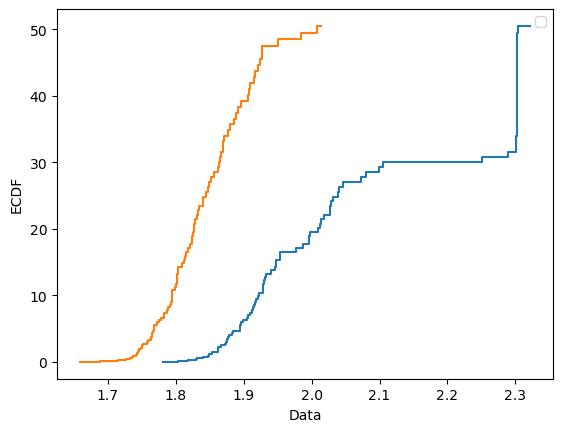

In [32]:
# Plot the ECDF
plt.step(sorted_losses1, ecdf1)
plt.step(sorted_losses2, ecdf2)
plt.xlabel('Data')
plt.ylabel('ECDF')
plt.legend()
plt.show()

We trained for 6 epochs, with this type of network we can achieve an accuracy of about 0.75 - 0.8. In our case we got about 0.72 which is satisfactory. Training the model for more epoch will end up yielding smaller improvements, capping bellow 0.8.

# Predicting the image class with our trainned model

First predict the accuracy for the validation dataset and then the test dataset.

In [ ]:

print(f"validation dataset accuracy: {evaluateModel(model, validate)}")

In [ ]:
%%time
print(f"test dataset accuracy: {evaluateModel(model, testLoader)}")

So we can see we have the accuracy and the loss pretty similar for the validation and test datasets. The accuracy of the test dataset is **0.5656**.

Let's define a new utility function to predict the label of an image based on the model.

In [ ]:
def predictImage(img, model):

    xb = img.unsqueeze(0)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)

    return pred[0].item()

Now we will plot maybe the most interesting image of the notebook, several images with the predicted and actual labels. Again we can see that the CIFAR-10 dataset is pretty hard, even for humans!

In [ ]:

with torch.no_grad():
    
    plt.subplots(figsize=(12, 10))
    
    for i in range(0, 12):
        img, label = testset[i]

        predictedValue = predictImage(img, model)
        
        
        plt.subplot(3, 4, i + 1)
        plt.title(f"predicted: {classes[predictedValue]} \n actual: {classes[label]}")
        plt.axis('off')
        plt.imshow(img.permute(1, 2, 0))

# Confusion matrix

No classification problem is not complete without a confudion matrix, so let's make one!

In [ ]:
predictions = np.empty((0, len(testset)), np.int32)
actualValues = np.empty((0, len(testset)), np.int32)

with torch.no_grad():
    for i in range(0, len(testset)):
        testImg, testLabel = testset[i]
        predictedValue = predictImage(testImg, model)

        predictions = np.append(predictions, predictedValue)
        actualValues = np.append(actualValues, testLabel)

In [ ]:
confusionMatrix = confusion_matrix(actualValues, predictions)

confusionMatrixDf = pd.DataFrame(confusionMatrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(confusionMatrixDf, annot=True, cmap='Blues', fmt='g')

Once again the confusion matrix does not dissapoint!

# Conclusion

The CIFAR-10 is a dificult data set to classify, but with CNNs we are up to the task! With PyTorch it is pretty easy to implement CNNs so our tasks is much easier.

Looking at the confusion matrix we can say that the classification of animals is the most deficult.

# Finish
You made it to the finish, thank you. Please upvote if you liked this noteboook.